# This notebook employs the Barlow Twins SSL technique to pretrain the DeepLabV3 backbone using seismic data


##  1. Initial setup

In [8]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
run_unity_tests = True
batch_size=12 # WARNING: this hyperparameter affects both GPU memory consumption and the backbone quality!

##  2. Creating a dataset with augmented views

Employ image transformations to create a dataset (and DataLoader) that retrieves augmented views of each sample.

First, instantiate a BarlowTwinsTransforms `transform` object. This class employs a set of image transformations (e.g., random resized crop, random horizontal flip, random color jitter, etc) to produce two views from each sample. Each time a sample is retrieved, the dataset invokes the transform object to generate a new pair of views.

In [9]:
from transforms.barlow_twins import BarlowTwinsTransforms
transform = BarlowTwinsTransforms()

Then, instantiate the data module using the transform object.

In [10]:
from data_modules.seismic import F3SeismicDataModule
pt_data_module = F3SeismicDataModule("data/", batch_size=batch_size, transform=transform)
pt_train_dl = pt_data_module.train_dataloader()

Now, lets take a look on the original and augmented samples.

torch.Size([3, 255, 701])


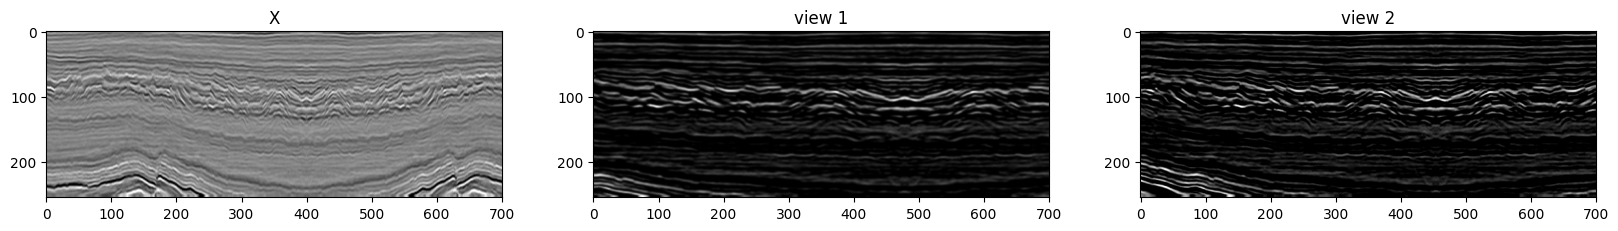

torch.Size([3, 255, 701])


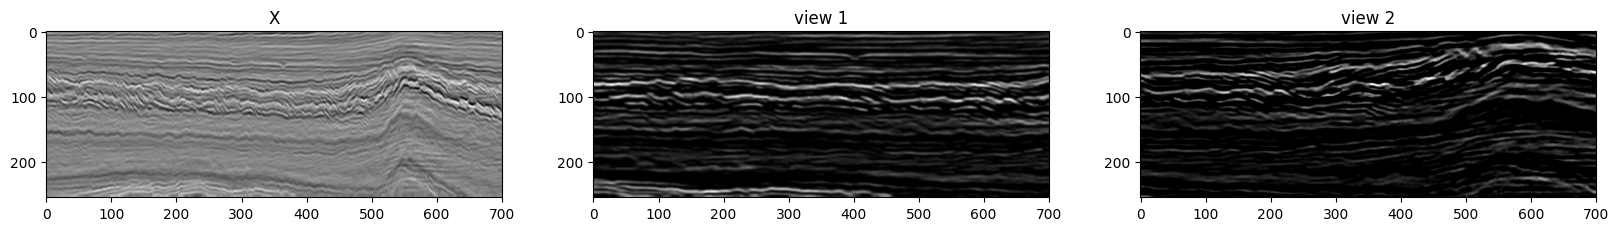

torch.Size([3, 255, 701])


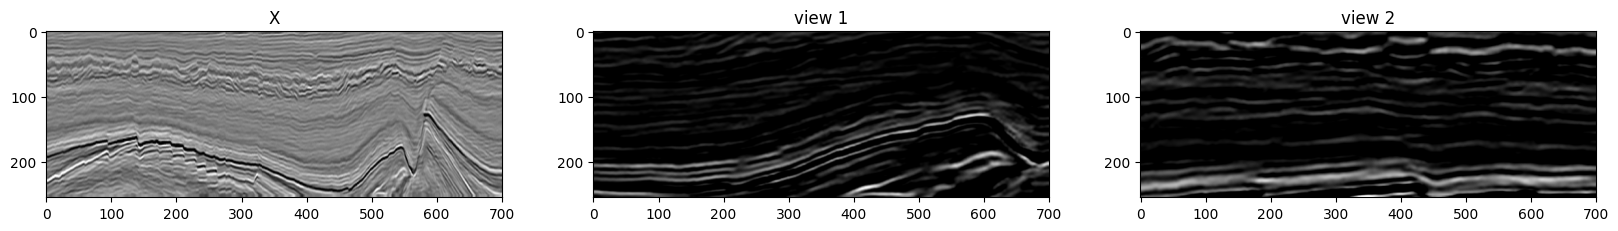

torch.Size([3, 255, 701])


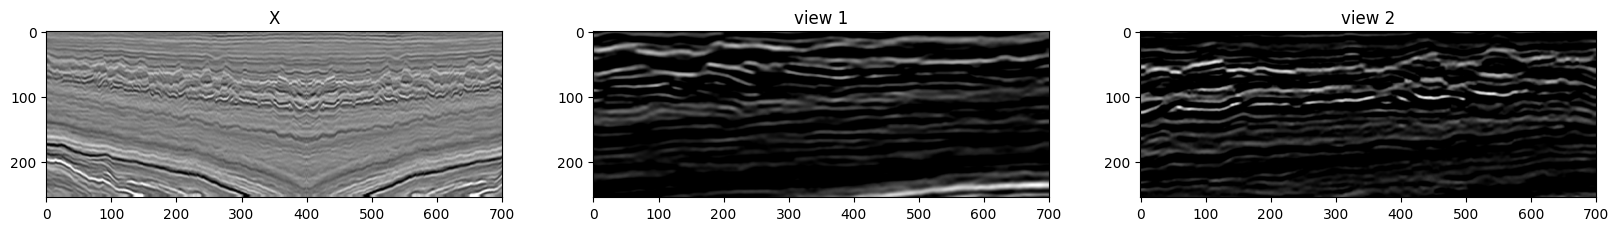

torch.Size([3, 255, 701])


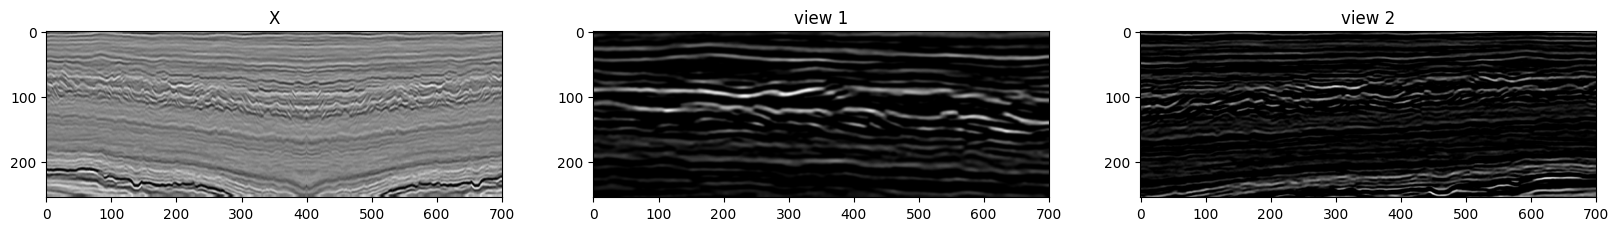

torch.Size([3, 255, 701])


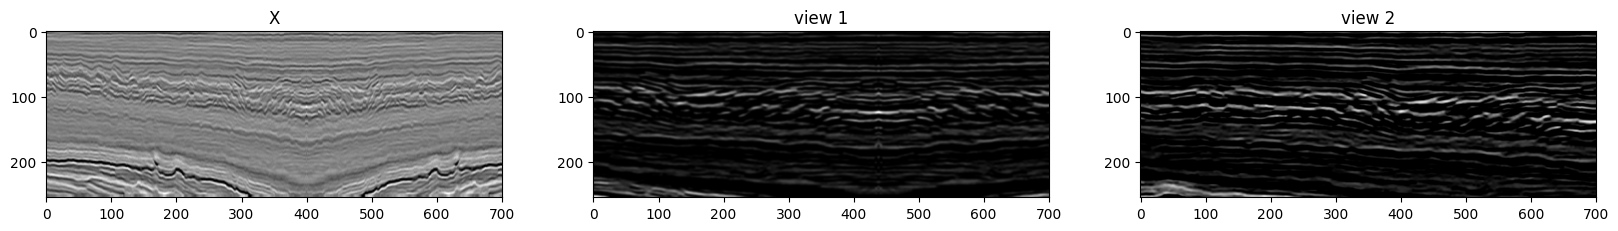

torch.Size([3, 255, 701])


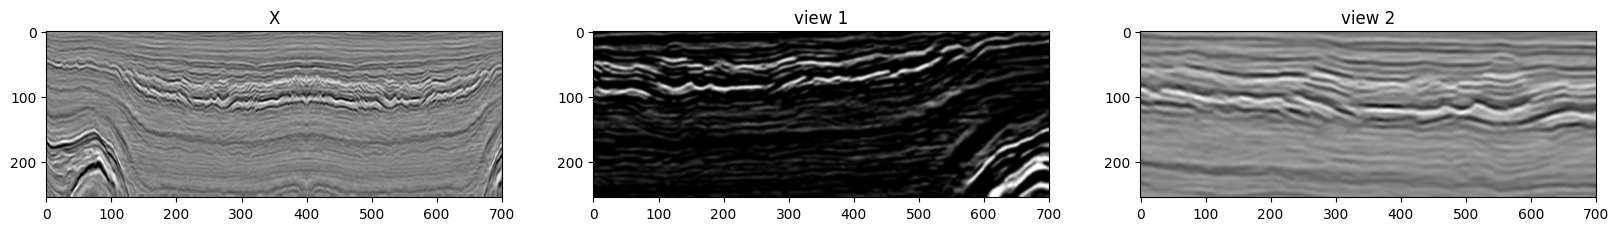

torch.Size([3, 255, 701])


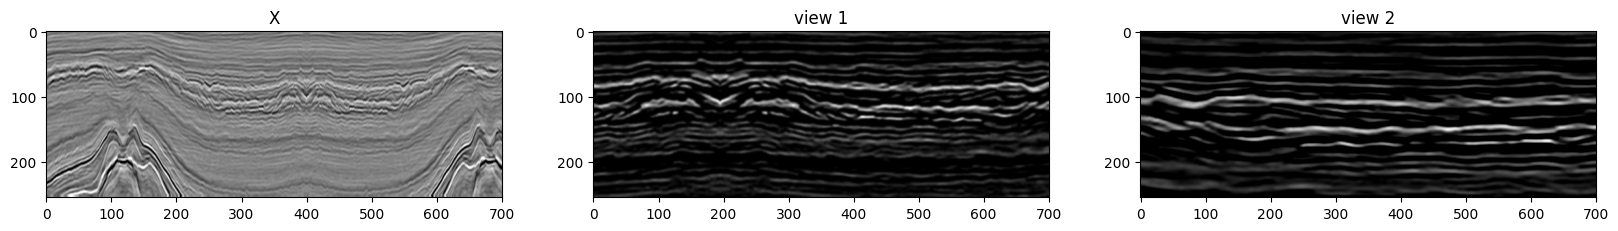

torch.Size([3, 255, 701])


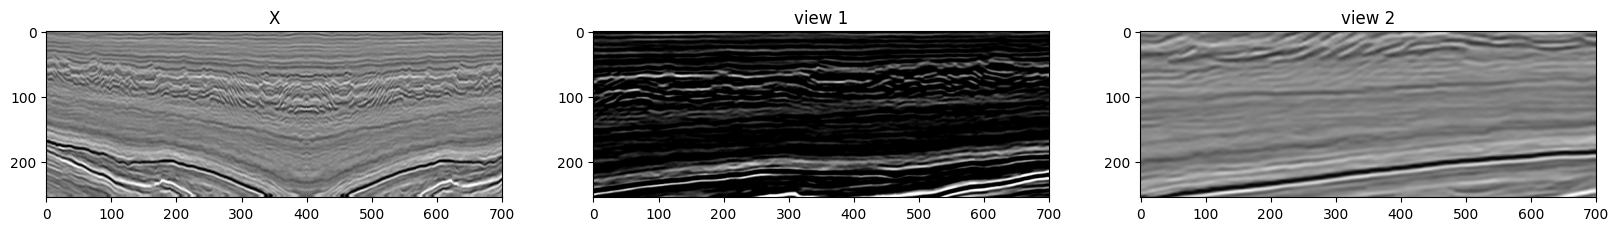

torch.Size([3, 255, 701])


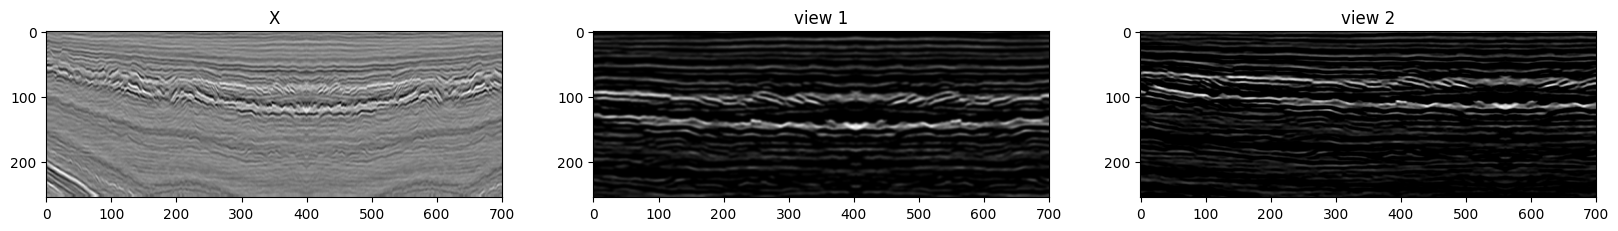

In [11]:
# Functions to display sample and views v1 and v2
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Plot the original and the two augmented views
def display_sample_views(x, v1, v2):
    plt.figure(figsize=(20,10))
    plt.subplot(1, 3, 1)
    plt.imshow(x[0, :, :].to("cpu").numpy(), cmap="gray")
    plt.title("X")
    plt.subplot(1, 3, 2)
    plt.imshow(v1[0, :, :].to("cpu").numpy(), cmap="gray")
    plt.title("view 1")
    plt.subplot(1, 3, 3)
    plt.imshow(v2[0, :, :].to("cpu").numpy(), cmap="gray")
    plt.title("view 2")
    plt.show()

# Lets inspect some of the samples 
nsamples = 10
for (x, v1, v2), y in iter(pt_train_dl):
    if nsamples<=0: break
    for i in range(len(x)):
        print(v2[i].shape)
        display_sample_views(x[i], v1[i], v2[i])
        nsamples-=1
        if nsamples<=0: break


##  3. Creating the backbone

Instantiate the DeepLabV3 backbone

In [12]:
import models.deeplabv3 as dlv3
backbone = dlv3.DeepLabV3Backbone()

The following code tests the backbone using a random batch with two samples of seismic images.
Notice that we are assuming seismic images are 255 x 701 images with 3 color channels.

In [13]:
if run_unity_tests:
    import torch
    random_input = torch.rand(2,3,255,701).to(device=device)
    backbone.to(device=device)
    z = backbone(random_input)
    output_shape = z.shape
    print("output_shape = ", output_shape)

output_shape =  torch.Size([2, 2048, 32, 88])


## 4. Creating the pretext model

First, lets create a projection head for the pretext task. This projection head will be coupled with the DeepLabV3 Backbone to form the pretext model.

We will attach an avgpool layer between the DeepLabV3 Backbone and the Barlow Twins Default Projection Head to reduce the dimensionality of the data. To do so, we will override the `preprocess_step()` method, which is invoked by the BT_ProjectionHead() object when performing the forward pass.

In [14]:
from torch import nn
import models.barlow_twins as bt

class BT_DeepLabV3ProjectionHead(bt.BT_ProjectionHead):
    def __init__(
        self, input_dim: int = 2048, 
        hidden_dim: int = 8192, 
        output_dim: int = 8192
    ):
        super(BT_DeepLabV3ProjectionHead, self).__init__(
            [
                (input_dim, hidden_dim, nn.BatchNorm1d(hidden_dim), nn.ReLU()),
                (hidden_dim, hidden_dim, nn.BatchNorm1d(hidden_dim), nn.ReLU()),
                (hidden_dim, output_dim, None, None)
            ]
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

    # Process the backbone: reduce dimensionality using avgpool and flatten the tensor to match 
    # the projection head input dimensionality (2048).
    def preprocess_step(self, x):
        return self.avgpool(x).flatten(start_dim=1)

In [15]:
import models.barlow_twins as bt
projection_head = BT_DeepLabV3ProjectionHead(input_dim=2048)
pretext_model = bt.BarlowTwins(backbone=backbone, projection_head=projection_head)

if run_unity_tests:
    import torch
    random_input = torch.rand(2,3,255,701).to(device=device)
    pretext_model.to(device=device)
    z = pretext_model(random_input)
    output_shape = z.shape
    print("output_shape = ", output_shape)

output_shape =  torch.Size([2, 8192])


## 5. Training the pretext model (i.e., the backbone)



In [17]:
import lightning as L

num_epochs=10
accelerator = "gpu"
trainer = L.Trainer(max_epochs=num_epochs, devices=1, log_every_n_steps=1, accelerator=accelerator)
trainer.fit(model=pretext_model, train_dataloaders=pt_train_dl)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                       | Params
---------------------------------------------------------------
0 | backbone        | DeepLabV3Backbone          | 25.6 M
1 | projection_head | BT_DeepLabV3ProjectionHead | 151 M 
2 | loss_fn         | BarlowTwinsLoss            | 0     
---------------------------------------------------------------
176 M     Trainable params
0         Non-trainable params
176 M     Total params
706.372   Total estimated model params size (MB)


Epoch 0:  22%|██▏       | 18/83 [00:11<00:39,  1.63it/s, v_num=119]

Save the backbone parameters

In [ ]:
filename = f'backbone_parameters-BT-pretext-with-{num_epochs}-epochs.pth'
torch.save(pretext_model.backbone.state_dict(), filename)
print(f"Backbone parameteres saved at {filename}")

Backbone parameteres saved at backbone_parameters-BT-pretext-with-10-epochs.pth
